## Guassian Process Regression

### Gaussian Distribution vs. Gaussian Process

Gaussian Distribution (Normal Distribution) describes the shape or probability of how data points in a dataset will be distributed, with the expression of: 

$$X \sim N(\mu, \Sigma)$$

Gaussian process a probability distribution over possible functions instead of data points. The idea is to model the unknown function that relates the input and output variables as a random draw from a Gaussian process. This allows us to make predictions on new input values by calculating the conditional distribution of the output variable given the input values and the training data. GP is fully expressed by its mean function and kernel function: 

$$X \sim GP(m(x),  k(x,x'))$$

$m(x)$: the mean function, describes the mean of any given data point x
$k(x,x')$: the kernel function, describes the relationship between any given two data points x and x'.

Kernel function: defines the covariance between different points in the input space, which determines how closely related these points are in terms of their output values. 

The most common kernel function is the radial basis function (RBF) kernel: 

$$k(x1, x2) = exp-\dfrac{(x1 - x2)^2}{2L^2}$$

One advantage of Gaussian regression is that it provides a probabilistic estimate of the predicted output, along with a measure of uncertainty. This is in contrast to other regression techniques, such as linear regression or decision trees, which only provide a point estimate of the predicted output. Additionally, Gaussian regression can be used for tasks such as Bayesian optimization, where the goal is to find the input values that maximize a given objective function.

/home/922361294/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Text(0, 0.5, 'Predicted')

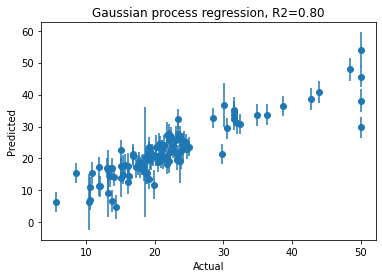

In [7]:
# GPR example using scikit-learn packages:
# reference: https://towardsdatascience.com/getting-started-with-gaussian-process-regression-modeling-47e7982b534d 
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
import matplotlib.pyplot as plt

X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# use a combined kernel
kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10) + WhiteKernel(5)
model = GaussianProcessRegressor(kernel=kernel)
model.fit(X_train, y_train)
y_pred_tr, y_pred_tr_std = model.predict(X_train, return_std=True)
y_pred_te, y_pred_te_std = model.predict(X_test, return_std=True)

plt.figure()
plt.errorbar(y_test, y_pred_te, yerr=y_pred_te_std, fmt='o')
plt.title('Gaussian process regression, R2=%.2f' % r2_score(y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')


Fit a GP to data:
 
$$ \hat{y} = \mu(X_*) + K_{*X} (K_{XX} + \sigma^2 I)^{-1} (y_{X} - \mu(X)) $$

$K_{*X}$ is the covariance matrix between test and training data, $K_{XX}$ is the covariance matrix between training and training data, $y_X$ is the predictive output from the training dataset.

In [8]:
# write my own kernel and GP model
import cupy as cp
import matplotlib.pyplot as plt

# Radial basis function (RBF) kernel
def RBF(x1, x2, length_scale=1.0):
    x1=cp.array(x1)
    x2=cp.array(x2)
    return cp.exp(-0.5 * (x1 - x2)**2 / length_scale ** 2)
'''
x1 = [[1,1,1],[2,2,2],[3,3,3]]
x2 = [[4,5,6], [4,5,6], [4,5,6]]
y = RBF(x1, x2)
print(y)
'''

# kernel/covariance matrix
def kernel_matrix(kernel, X1, X2, L=1.0, sigma=1e-6):
    # let's first assum X1 and X2 are both one-dimensional, can use cp.hstack() to transform them into one-dimension
    size1 = X1.shape[0]
    size2 = X2.shape[0]
    X1 = cp.reshape(X1, [size1,1])
    X2 = cp.reshape(X2, [1, size2])
    m = X1.shape[0]
    n = X2.shape[1]
    X1_trans = cp.repeat(X1, n, axis=1)
    X2_trans = cp.repeat(X2, m, axis=0) 
    #print(X1_trans)
    #print(X2_trans)
    return kernel(X1,X2,L)

def mu(x):
    return x

def GP_fit(x_train, x_test, y_train, y_test, k, mu, kernel_matrix, L = 1.0, sigma = 1e-6):
    # GP_fit with this function:
    # y = mu(X_*) + K_{*X} (K_{XX} + \sigma^2 I)^{-1} (y_{X} - \mu(X))
    
    K_train_test = kernel_matrix(k, x_test, x_train, L, sigma)
    K_train_train = kernel_matrix(k, x_train, x_train, L, sigma)

    K_y = cp.linalg.inv(K_train_train - (sigma * cp.identity(x_train.shape[0]) ))
    post_mean = mu(x_test) + ( (K_train_test @ K_y) @ (y_train - mu(x_train)) )
    return post_mean

'''
x1 = cp.array([1,2,3,4])
x2 = cp.array([5,6])
kernel_mat = kernel_matrix(RBF, x1, x2)
print(kernel_mat)
'''

X_train = cp.array([1., 7., 4.])
X_test = cp.array([2.5, 5.3])

y_train = cp.array([1.4,0.6,9.4])
y_test = cp.array([4.,1.])

# use the same dataset for both training and testing
post_mean = GP_fit(X_train, X_train, y_train, y_train, RBF, mu, kernel_matrix)
print(post_mean)
print(y_train)



[1.40000034 0.59999354 9.40000547]
[1.4 0.6 9.4]


The above GPR model works for 1-dimensional data input.

Write a GPR model which works for multiple dimension data input.

One question to be answered: <b>Do I need to add mean(x_train) and mean(x_test) in GPR?</b>

In Gaussian Process Regression, it is not necessary to subtract the mean of train_x or test_x.

The prior over functions is assumed to be a zero-mean Gaussian process. This means that the mean of the data is already accounted for by the kernel function. The kernel function specifies the covariance between points in the input space, and it incorporates both the mean and variance of the data.

Thus, it is common to center the training data by subtracting the mean of the train_x from both the train_x and test_x. This can help improve numerical stability and make the optimization problem more well-behaved. However, it is not strictly necessary to do so, as the kernel function is designed to handle data with non-zero means.

In [20]:
import cupy as cp

class GaussianRegressor:
    def __init__(self, kernel):
        self.kernel = kernel
        self.sigma = None
        self.X = None
        self.y = None

    def fit(self, X, y, sigma=1e-6):
        self.sigma = sigma
        self.X = X
        self.y = y

    def predict(self, Xtest):
        K = self.kernel(self.X, self.X) + self.sigma * cp.eye(len(self.X))
        K_train_test = self.kernel(self.X, Xtest)
        K_test_test = self.kernel(Xtest, Xtest) + self.sigma * cp.eye(len(Xtest))
        
        #mean = K_train_test.T @ cp.linalg.inv(K) @ self.y

        # mu(x_train) and mu(x_test) are not strictly required
        mean = mu(Xtest) + K_train_test.T @ cp.linalg.inv(K) @ (self.y - mu(self.X))

        # returned cov represents the uncertainty associated with the predicted mean at each test point
        cov = K_test_test - K_train_test.T @ cp.linalg.inv(K) @ K_train_test
        std = cp.sqrt(cp.diag(cov))

        return mean, cov, std

# Define the RBF kernel
# now X1 and X2 are m1-n and m2-n dimensional matrix
# X1 and X2 have the same column number n which denotes the number of featrues
# X1 and X2 have different first dimension m1 and m2 which denote number of data point
def rbf_kernel(X1, X2, length_scale=1.0):
    cp.atleast_2d(X1)
    cp.atleast_2d(X2)
    s1 = X1.shape
    s2 = X2.shape
    
    if (s1[1] != s2[1]):
        print("ERROR! RBF input matices must have the same number of columns!")
        return

    dists = cp.sum((X1[:, cp.newaxis] - X2) ** 2, axis=2)
    return cp.exp(-dists / (2 * length_scale ** 2))

def mu(x):
    n = x.shape[1]
    return cp.sum(x,axis=1) / n

'''
X1 = cp.array([[1.,2.,3.],[3.,4.,5.],[5.,6.,7.]])
X2 = cp.array([[2.,3.,4.],[7.,8.,9.],[9.,10,11.]])
cov = rbf_kernel(X1, X2)
print(cov)

>> output is:
[[2.23130160e-01 3.53262857e-24 2.03109266e-42]
 [2.23130160e-01 3.77513454e-11 3.53262857e-24]
 [1.37095909e-06 2.47875218e-03 3.77513454e-11]]
'''

X1 = cp.array([[1.,2.,3.],[3.,4.,5.],[5.,6.,7.]])
y = cp.array([2.,4.,6.])
gr = GaussianRegressor(rbf_kernel)
gr.fit(X1,y)

# use the same data set as training, y_pred should be similar to y
y_pred, cov, std = gr.predict(X1)

print('y is: ' + str(y))
print('y_pred is: ' + str(y_pred))
print('cov: \n' + str(cov))
print('std: ' + str(std))



y is: [2. 4. 6.]
y_pred is: [2. 4. 6.]
cov: 
[[ 1.99999900e-06  2.47891985e-15 -6.14337930e-18]
 [ 2.47891985e-15  1.99999900e-06  2.47935353e-15]
 [-6.14464592e-18  2.47891985e-15  1.99999900e-06]]
std: [0.00141421 0.00141421 0.00141421]


## GPR with Cholesky

### what is Cholesky?

Cholesky decomposition (or factorization) is a more efficiently method for solving a linear system of equations,especially for large and sparse matrices.

Every symetric and positive semi-definite matrix $A$ can be decomposed into: $A = L * L^T$

where L is a lower triangular matrix. The elements of L are calculated using the following equations:

If symetric and positive semi-definite matrix $A$ satisfies the linear system quation $Ax = b$, then this system equation ($L * L^T * x = b$) can be solved more efficiently using Cholesky decomposition with two steps: 

1. Forward substitution: Solve $Ly = b$ for y using forward substitution.

2. Backward substitution: Solve $L^Tx = y$ for x using backward substitution.

In [22]:
import cupy as cp

class GaussianRegressorCholesky:
    def __init__(self, kernel):
        self.kernel = kernel
        self.sigma = None
        self.X = None
        self.y = None

    def fit(self, X, y, sigma=1e-6):
        self.sigma = sigma
        self.X = X
        self.y = y
        self.K = self.kernel(X, X) + self.sigma**2 * cp.eye(len(X))
        self.L = cp.linalg.cholesky(self.K)
        # let alpha = inv(K) * y => K * alpha = y => L*L.T * alpha = y => alpha = solve(L.T, solve(L, y))
        self.alpha = cp.linalg.solve(self.L.T, cp.linalg.solve(self.L, y))

    def predict(self, Xtest):
        K_train_test = self.kernel(self.X, Xtest)
        mean = K_train_test.T @ self.alpha

        # L*v = K => v = inv(L)*K => v.T * v = K.T * inv(L.T) * inv(L) * K = K.T * inv(L*L.T) * K
        v = cp.linalg.solve(self.L, K_train_test)
        cov = self.kernel(Xtest, Xtest) - v.T @ v
        std = cp.sqrt(cp.diag(cov))

        return mean, cov, std


X1 = cp.array([[1.,2.,3.],[3.,4.,5.],[5.,6.,7.]])
y = cp.array([2.,4.,6.])
gr = GaussianRegressorCholesky(rbf_kernel)
gr.fit(X1,y)

# use the same data set as training, y_pred should be similar to y
y_pred, cov, std = gr.predict(X1)

print('y is: ' + str(y))
print('y_pred is: ' + str(y_pred))
print('cov: \n' + str(cov))
print('std: ' + str(std))

y is: [2. 4. 6.]
y_pred is: [2. 4. 6.]
cov: 
[[1.00008890e-12 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00019992e-12 4.33680869e-19]
 [0.00000000e+00 4.33680869e-19 1.00019992e-12]]
std: [1.00004445e-06 1.00009996e-06 1.00009996e-06]


## GPR with Derivatives
A Gaussian process is a collection of random variables, any finite subset of which has a joint Gaussian distribution. In machine learning, it is often used as a probabilistic model for regression and classification tasks, where the goal is to learn a mapping from input variables to output variables.

In some cases, it can be useful to model not just the output variables, but also their derivatives. This can be done using a variant of the Gaussian process called a Gaussian process with derivatives (GPD). In a GPD, the joint distribution over the function values and their derivatives is still Gaussian, but the covariance function is modified to include information about the derivatives.

A Gaussian regression with derivatives model is a type of machine learning model that uses Gaussian functions to model the relationship between a set of input variables and a target variable, as well as the derivatives of the target variable with respect to the input variables. The model is typically used for regression problems, where the goal is to predict a continuous output variable.

The basic form of the model is:

y(x) = w0 + w1G1(x) + w2G2(x) + ... + wN*GN(x)

where y(x) is the target variable, x is a vector of input variables, and G1(x), G2(x), ..., GN(x) are Gaussian functions centered at different points in the input space. The parameters w0, w1, ..., wN are the weights that are learned during training.

In addition to modeling the target variable, the model also includes terms for the derivatives of the target variable with respect to the input variables. These terms are given by:

dy(x)/dx1 = a1G1'(x) + a2G2'(x) + ... + aNGN'(x)
dy(x)/dx2 = b1G1'(x) + b2G2'(x) + ... + bNGN'(x)
...
dy(x)/dxN = z1G1'(x) + z2G2'(x) + ... + zN*GN'(x)

where G1'(x), G2'(x), ..., GN'(x) are the first derivatives of the Gaussian functions, and a1, a2, ..., aN, b1, b2, ..., bN, ..., z1, z2, ..., zN are the weights for the derivative terms.

The final form of the model is:

y(x) = w0 + w1G1(x) + w2G2(x) + ... + wN*GN(x) +
dy(x)/dx1 + dy(x)/dx2 + ... + dy(x)/dxN

During training, the weights w0, w1, ..., wN and a1, a2, ..., aN, b1, b2, ..., bN, ..., z1, z2, ..., zN are learned by minimizing the mean squared error between the model predictions and the true values of the target variable. The resulting model can then be used to predict the target variable and its derivatives for new inputs.

In [50]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import cupy as cp

class GaussianRegressionWithDerivatives(BaseEstimator, RegressorMixin):
    def __init__(self, kernel=None, alpha=0.0):
        self.kernel = kernel
        self.alpha = alpha
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Create kernel for Gaussian process regression
        if self.kernel is None:
            self.kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + \
                          WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e2))
        self.gpr = GaussianProcessRegressor(kernel=self.kernel, alpha=self.alpha, normalize_y=True)
        
        # Compute derivatives of y with respect to each feature
        dy = cp.zeros((n_samples, n_features))
        for i in range(n_features):
            #X1 = cp.delete(X, i, axis=1)
            X1 = cp.concatenate((X[:,:i], X[:,i+1:]), axis=1)
            print('the shape of X1 after deleting one column is: ' + str(X1.shape))
            #y1 = self.gpr.fit(X1, cp.gradient(y, axis=0)[:, i]).predict(X1, return_std=False)
            y1 = self.gpr.fit(X1, cp.gradient(y, axis=0)).predict(X1, return_std=False)
            #dy[:, i] = cp.gradient(y1, axis=0) / cp.gradient(X[:, i], axis=0)
            dy[:, i] = cp.gradient(y1, axis=0) / cp.gradient(X[:, i], axis=0)
            
        # Fit the model with y and its derivatives
        X_aug = cp.concatenate((X, dy), axis=1)
        self.gpr.fit(X_aug, y)
        return self
        
    def predict(self, X):
        n_samples, n_features = X.shape
        
        # Compute derivatives of X
        dX = np.zeros((n_samples, n_features))
        for i in range(n_features):
            dX[:, i] = np.gradient(X[:, i], axis=0)
        
        # Predict y and its derivatives
        X_aug = cp.concatenate((X, dX), axis=1)
        y_pred = self.gpr.predict(X_aug, return_std=False)
        dy_pred = self.gpr.predict(X_aug, return_std=False, jac=True)[1]
        
        return y_pred, dy_pred

X1 = cp.array([[1.,2.,3.],[3.,4.,5.],[5.,6.,7.]])
y = cp.array([2.,4.,6.])
gr = GaussianRegressionWithDerivatives()
gr.fit(X1,y)

# use the same data set as training, y_pred should be similar to y
y_pred, dy_pred = gr.predict(X1)

print('y is: ' + str(y))
print('y_pred is: ' + str(y_pred))
print('dy_pred: \n' + str(dy_pred))

the shape of X1 after deleting one column is: (3, 2)


TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [43]:
import cupy as cp

# create a 3x3 matrix
a = cp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# delete the second column (index 1) and modify the original array in place
b = cp.concatenate((a[:,:1], a[:,2:]), axis=1)

print(a)
print(b)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 3]
 [4 6]
 [7 9]]


In [47]:
import cupy as cp

# create a 2D array
a = cp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# compute the gradient of the array
grad_x, grad_y = cp.gradient(a)

print(grad_x)
print(grad_y)


[[3. 3. 3.]
 [3. 3. 3.]
 [3. 3. 3.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
